## Задача №1

<b>1. Что такое автокорреляционная функция? А частная автокорреляционная функция?</b><br><br>
Функция автокорреляции (АКФ)- при лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов.<br>
Функция частной автокорреляции (ЧАКФ)- при лаге k это корреляция между рядами значений, отстоящих друг от друга на k интервалов, считая значения интервалов в промежутке.<br><br>
<b>2. Какой временной ряд называется стационарным? Может ли временной ряд с трендом быть стационарным? А с циклом?</b><br><br>
    Временной ряд X1, . . . , XN называется стационарным, если его вероятностные характеристики (среднее, дисперсия и автокорреляция) не меняются с течением времени.<br>
    Временные ряды с трендом или сезонностью не являются стационарными. При этом ряды с циклами могут быть стационарными, поскольку положение максимумов и минимумов этого ряда заранее предсказать нельзя.<br><br>
<b>3. Какую гипотезу проверяет критерий Дики-Фуллера?</b><br><br>
Критерий Дики-Фуллера для проверяет гипотезу о стационарности ряда.<br><br>
<b>4. Какой временной ряд можно хорошо описать с помощью модели ARMA?</b><br><br>
Любой стационарный временной ряд может быть хорошо описать моделью ARMA(p,q) с правильным подбором значений параметров p, q.<br><br>
<b>5. На что нужно обращать при анализе остатков модели?</b><br><br>
В анализе временных рядов важно обращать на следующие характеристики остатков: несмещенность, стационарность и неавтокоррелированность.<br>
1. Остатки модели должны быть несмещенными, то есть их среднее должно быть равно нулю. Лучше всего проверять несмещенность визуально, но можно и с помощью изученных критериев (знаков или Уилкоксона).<br>
2. Остатки модели должны быть стационарными, то есть не обладать какой-либо зависимостью от времени. Лучше всего проверять стационарность визуально, но можно и с помощью критерия Дики-Фуллера.<br>
3. Остатки модели должны образовывать независимую выборку, то есть не обладать значимой автокорреляцией. Лучше всего проверять отсутствие зависимости по графику автокорреляционной функции (ACF), но можно и с помощью Q-критерия Льюнга-Бокса.<br><br>

In [285]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from itertools import product
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [63]:
from scipy.special import inv_boxcox # обратное преобразование Бокса-Кокса 
from itertools import product # произведения множеств

In [64]:
import sys
import datetime
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize


## Задача №2

In [259]:
data = pd.read_csv("shampoo.csv", sep=',', index_col=['Month'], parse_dates=['Month'], dayfirst=False)
data = data.rename(columns={"Sales": "sales"})

data.head()

,sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


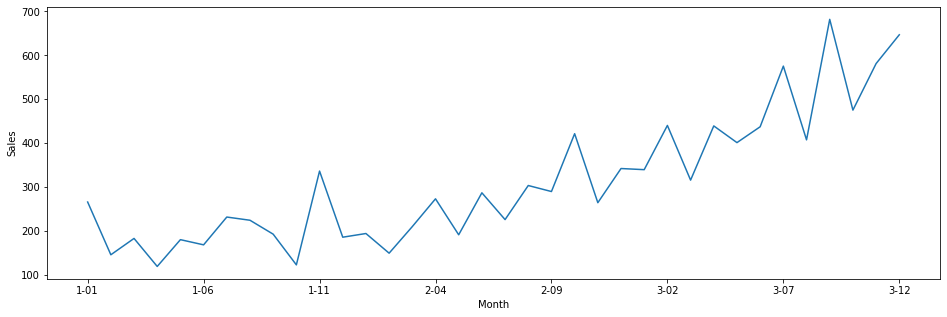

In [34]:
plt.figure(figsize=(16,5))
data.sales.plot()
plt.ylabel('Sales')
plt.show()

Критерий Дики-Фуллера: p=1.000000


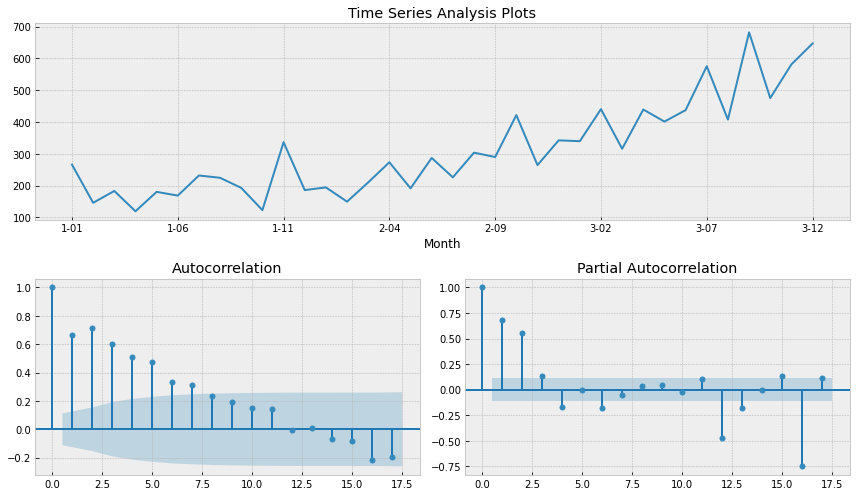

In [37]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(data.sales, lags=17)

Критерий Дики-Фуллера: p=0.997834
Оптимальный параметр преобразования Бокса-Кокса: -0.098295


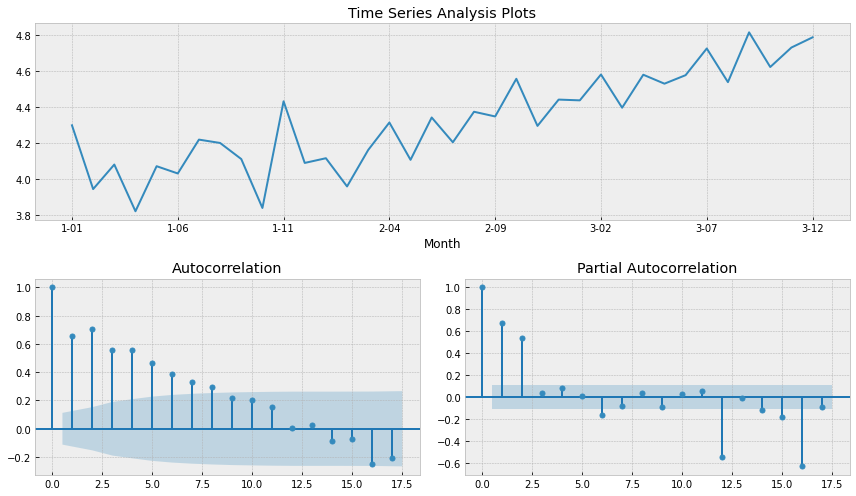

In [261]:
def invboxcox(y,lmbda):
    # обратное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data['sales_box'], lmbda = scs.boxcox(data.sales+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.sales_box, lags=17)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.001590


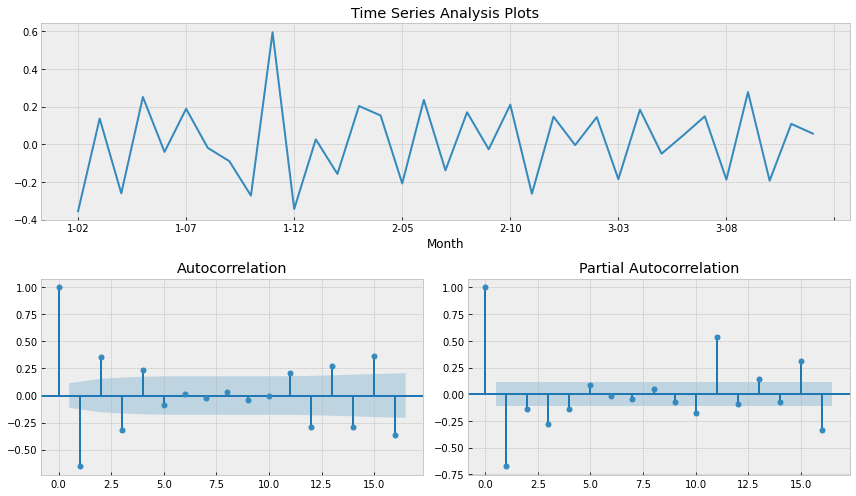

In [119]:
data['sales_box_dif'] = data.sales_box - data.sales_box.shift(1)
tsplot(data.sales_box_dif[1:], lags=16)

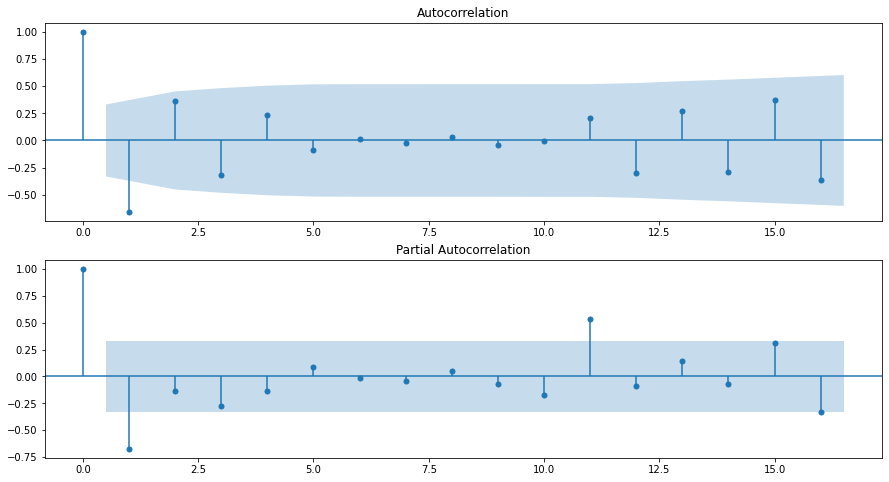

In [120]:

fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(data.sales_box_dif[1:].values.squeeze(), lags=16, ax=ax1)
sm.graphics.tsa.plot_pacf(data.sales_box_dif[1:].values.squeeze(), lags=16, ax=ax2)

plt.show()

Согласно этим графикам, в качестве начальных значений необходимо взять: $q=1$, $p=1$.

In [262]:
d= 1
ps = range(0, 4)
qs = range(0, 4)


parameters = product(ps ,qs)
parameters_list = list(parameters)

In [267]:
results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.sales_box, order=(param[0], d, param[1])).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])

100%|██████████| 16/16 [00:03<00:00,  5.33it/s]


In [268]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
14,"(3, 2)",-29.767873
11,"(2, 3)",-28.057071
15,"(3, 3)",-27.945338
4,"(1, 0)",-27.075092
2,"(0, 2)",-27.055548


In [269]:
best_model=sm.tsa.statespace.SARIMAX(data.sales_box, order=(0,1,2)).fit(disp=-1)

print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:              sales_box   No. Observations:                   36
Model:               SARIMAX(0, 1, 2)   Log Likelihood                  16.528
Date:                Mon, 28 Jun 2021   AIC                            -27.056
Time:                        20:49:04   BIC                            -22.390
Sample:                             0   HQIC                           -25.445
                                 - 36                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0197      0.165     -6.168      0.000      -1.344      -0.696
ma.L2          0.4332      0.129      3.346      0.001       0.179       0.687
sigma2         0.0221      0.006      3.476      0.0

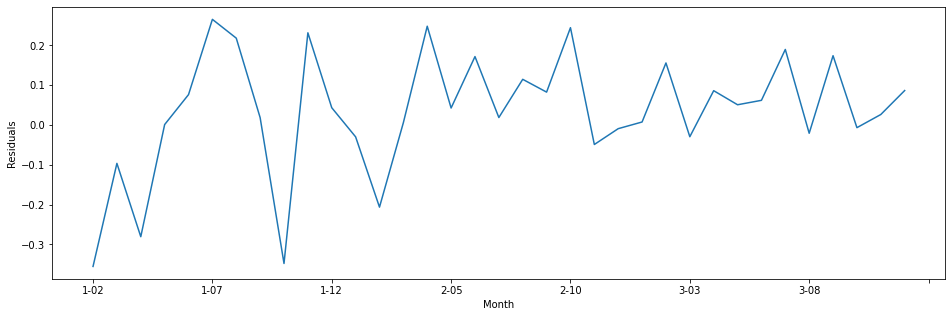

In [91]:
plt.figure(figsize(16,5))
best_model.resid[1:].plot()
plt.ylabel('Residuals')
plt.show()

In [94]:

from statsmodels.stats.descriptivestats import sign_test
print("Критерий знаков для остатков: pvalue =",sign_test(best_model.resid[1:])[1])

Критерий знаков для остатков: pvalue = 0.04095959151163695


In [95]:
print("Критерий Дики-Фуллера для остатков: pvalue =",sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

Критерий Дики-Фуллера для остатков: pvalue = 0.000267059800040877


<Figure size 1152x360 with 0 Axes>

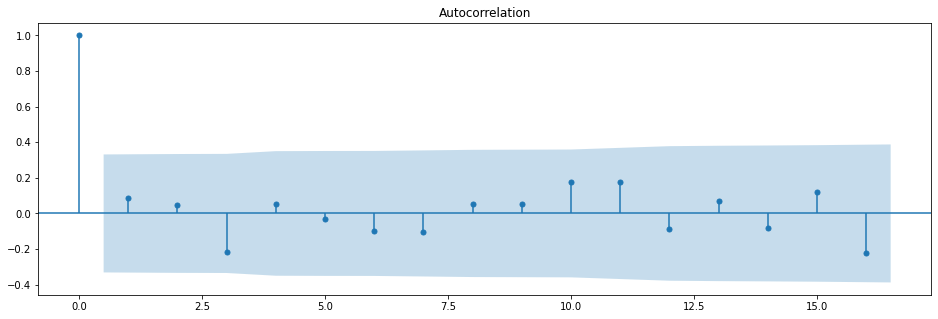

In [97]:
plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[1:].values.squeeze(), lags=16)
plt.show()

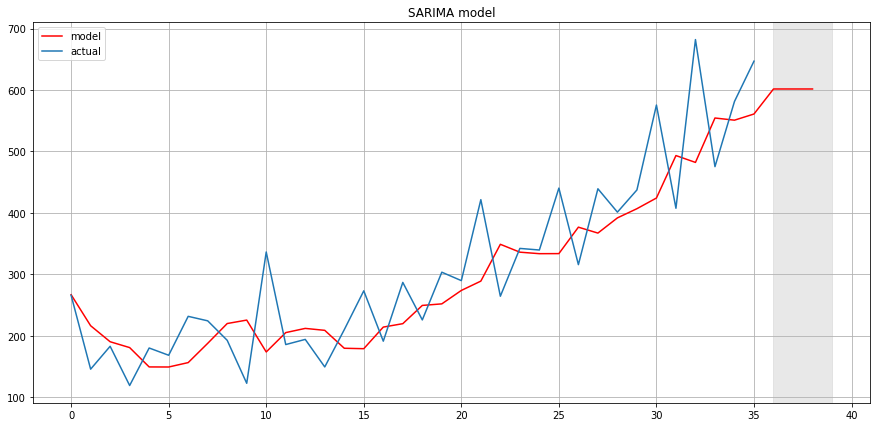

In [270]:
data["model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+3), lmbda)
forecast = data.model.append(forecast).values[-39:]
actual = data.sales.values[-36:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model")
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

Сезонность отсутсвует. Тренд присутствует. Т.к. данных мало, точную зависимость установить не получилось, однако тренд совпадает.

In [121]:
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

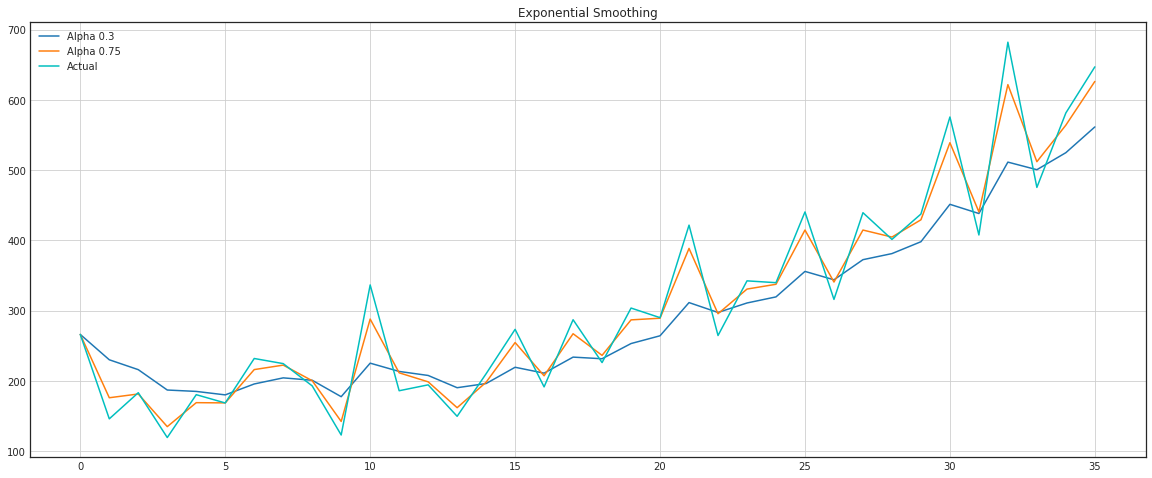

In [124]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.75]:
        plt.plot(exponential_smoothing(data.sales, alpha), label="Alpha {}".format(alpha))
    plt.plot(data.sales.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True)

Можно предсказать при помощи экспоненциального сглаживания.

## Задача №4

In [273]:

data = pd.read_csv("female-births.csv", sep=',', index_col=['Date'], parse_dates=['Date'], dayfirst=False)

data = data.rename(columns={"Births": "births"})
data.head()

,births
Date,
1959-01-01,35
1959-01-02,32
1959-01-03,30
1959-01-04,31
1959-01-05,44


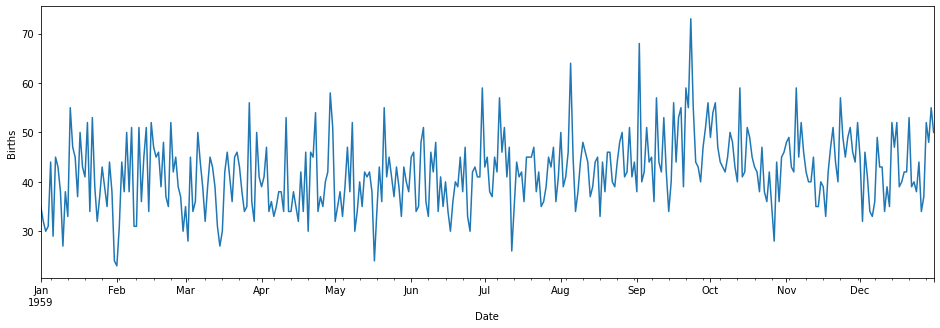

In [274]:

plt.figure(figsize=(16,5))
data.births.plot()
plt.ylabel('Births')
plt.show()

<Figure size 1152x576 with 0 Axes>

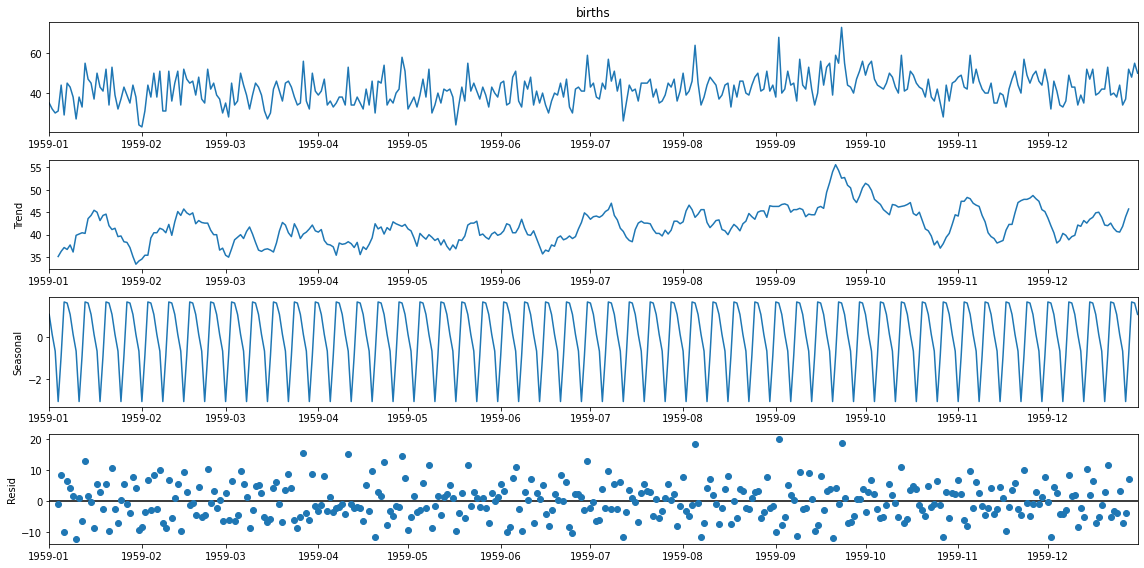

In [275]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.births).plot()
plt.show()

Критерий Дики-Фуллера: p=0.000052


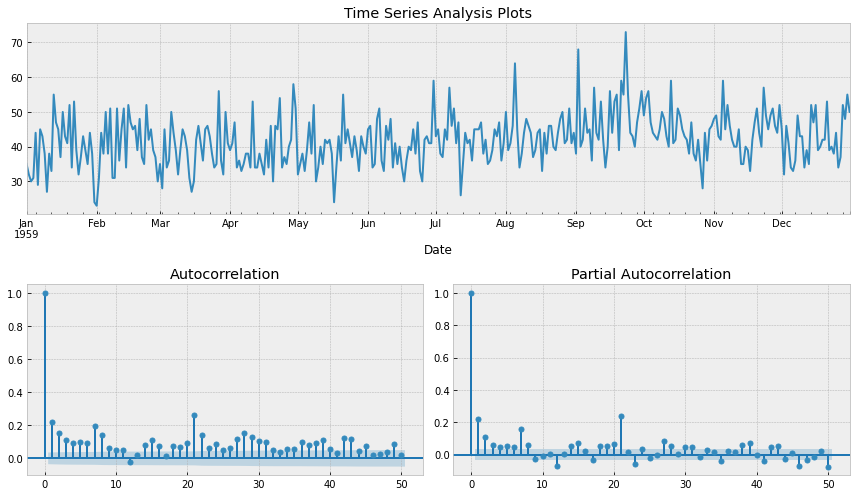

In [276]:
tsplot(data.births, lags=50)

Критерий Дики-Фуллера: p=0.000372
Оптимальный параметр преобразования Бокса-Кокса: 0.271221


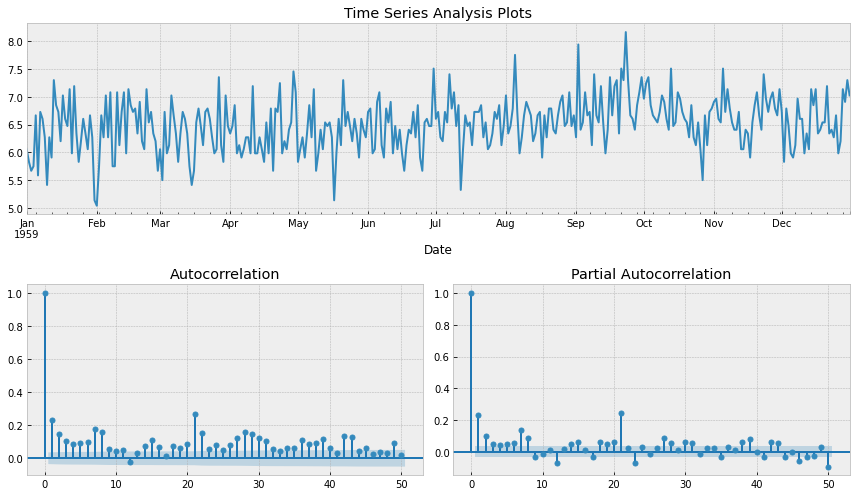

In [277]:

data['birth_box'], lmbda = scs.boxcox(data.births+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.birth_box, lags=50)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

<Figure size 1152x576 with 0 Axes>

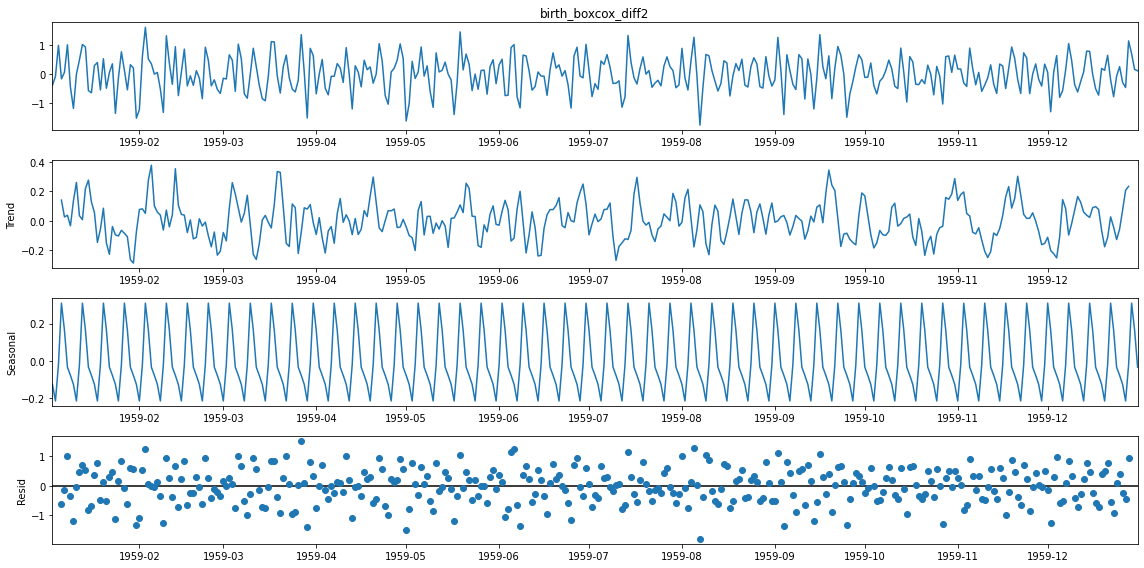

In [278]:
data['birth_boxcox_diff2'] = data.birth_box - data.birth_box.shift(2)
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.birth_boxcox_diff2[2:]).plot()
plt.show()

Изначальный ряд стационарен. Критерий Дики-Фуллера это подтвержает.

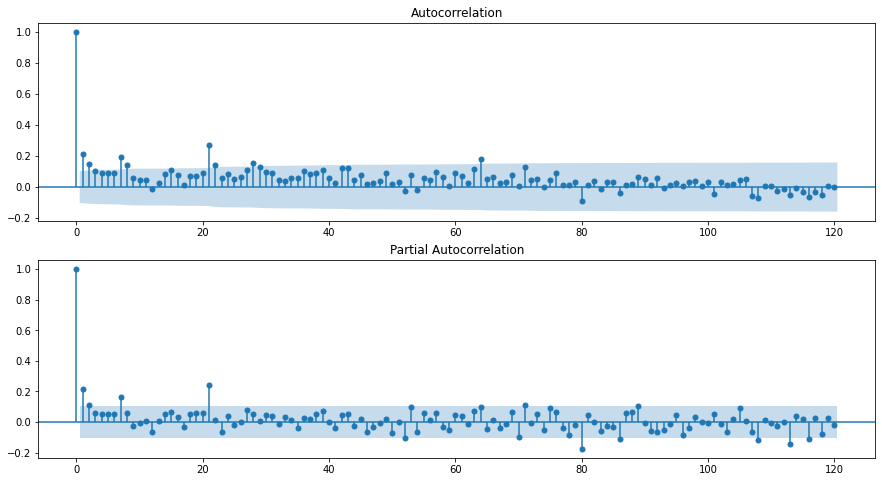

In [279]:
fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(data.births[1:].values.squeeze(), lags=120, ax=ax1)
sm.graphics.tsa.plot_pacf(data.births[1:].values.squeeze(), lags=120, ax=ax2)

plt.show()

In [280]:
d=D= 1
ps = range(0, 2)
qs = range(0, 3)
Ps = range(0, 5)
Qs = range(0, 5)


parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.birth_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3],4)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])
    
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']
result_table.sort_values(by = 'AIC', ascending=True).head()

100%|██████████| 150/150 [05:29<00:00,  2.20s/it]


,Parameters,AIC
113,"(1, 1, 2, 3)",476.329802
63,"(0, 2, 2, 3)",477.224284
114,"(1, 1, 2, 4)",477.800292
116,"(1, 1, 3, 1)",478.427969
64,"(0, 2, 2, 4)",478.436333


In [282]:
best_model=sm.tsa.statespace.SARIMAX(data.birth_box, order=(0,1,2), seasonal_order=(2,1,3,4)).fit(disp=-1)
print(best_model.summary())

                                         SARIMAX Results                                         
Dep. Variable:                                 birth_box   No. Observations:                  365
Model:             SARIMAX(0, 1, 2)x(2, 1, [1, 2, 3], 4)   Log Likelihood                -230.612
Date:                                   Mon, 28 Jun 2021   AIC                            477.224
Time:                                           21:00:50   BIC                            508.313
Sample:                                       01-01-1959   HQIC                           489.586
                                            - 12-31-1959                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8392      0.053    -15.920      0.000    

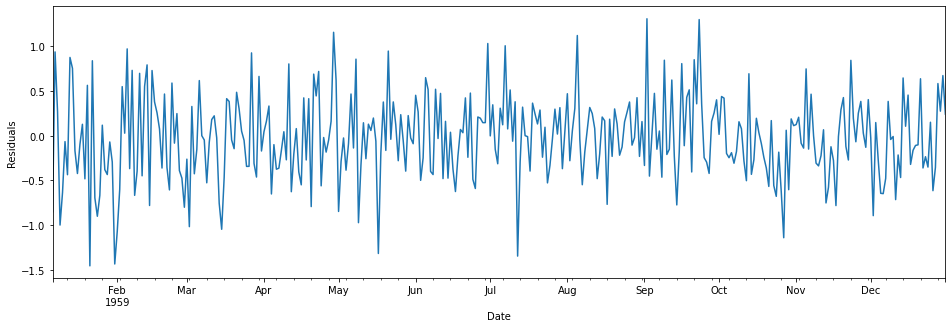

In [172]:
plt.figure(figsize(16,5))
best_model.resid[4:].plot()
plt.ylabel('Residuals')
plt.show()

Критерий знаков для остатков: pvalue = 0.023300037850797962
Критерий Дики-Фуллера для остатков: pvalue = 0.0


<Figure size 1152x360 with 0 Axes>

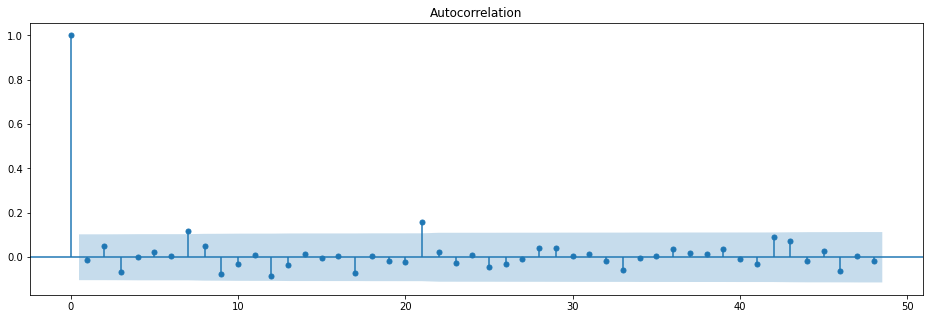

In [221]:
print("Критерий знаков для остатков: pvalue =",sign_test(best_model.resid[5:])[1])
print("Критерий Дики-Фуллера для остатков: pvalue =",sm.tsa.stattools.adfuller(best_model.resid[5:])[1])
plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[5:].values.squeeze(), lags=48)
plt.show()

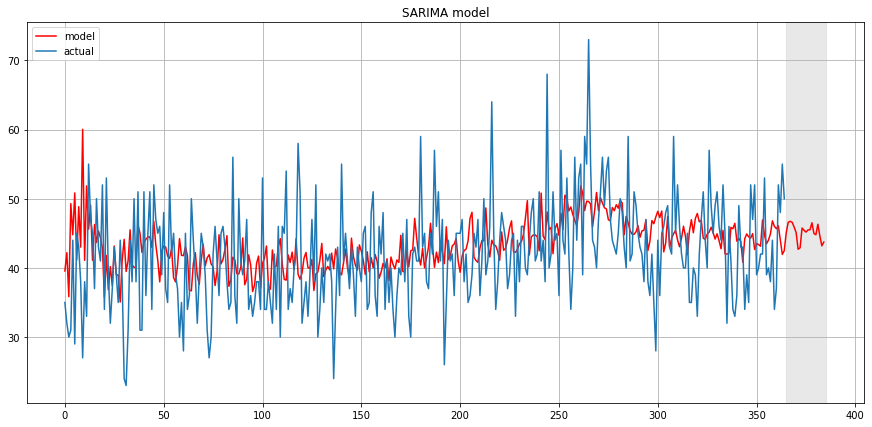

In [284]:
data["model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+30), lmbda)
forecast = data.model.append(forecast).values[-385:]
actual = data.births.values[-365:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model")
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)

## Задача №3

In [224]:
data = pd.read_csv("anti-diabetic-drugs.csv", sep=',') 
data

,date,value
0,1991-07-01,3.526591
1,1991-08-01,3.180891
2,1991-09-01,3.252221
3,1991-10-01,3.611003
4,1991-11-01,3.565869
...,...,...
199,2008-02-01,21.654285
200,2008-03-01,18.264945
201,2008-04-01,23.107677
202,2008-05-01,22.912510


In [225]:
data = pd.read_csv("anti-diabetic-drugs.csv", sep=',', index_col=['date'], parse_dates=['date'], dayfirst=False)

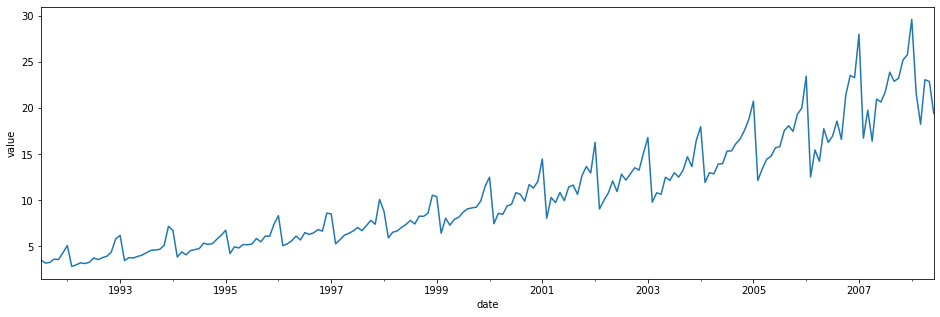

In [227]:
plt.figure(figsize=(16,5))
data.value.plot()
plt.ylabel('value')
plt.show()

<Figure size 1152x576 with 0 Axes>

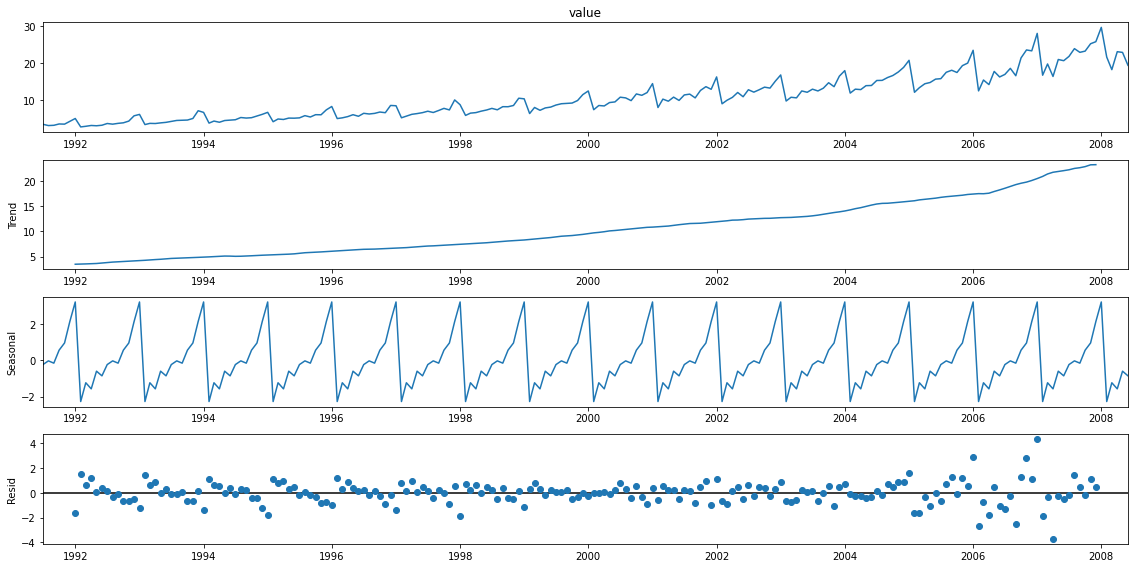

In [228]:
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.value).plot()
plt.show()

Критерий Дики-Фуллера: p=0.900152
Оптимальный параметр преобразования Бокса-Кокса: -0.027788


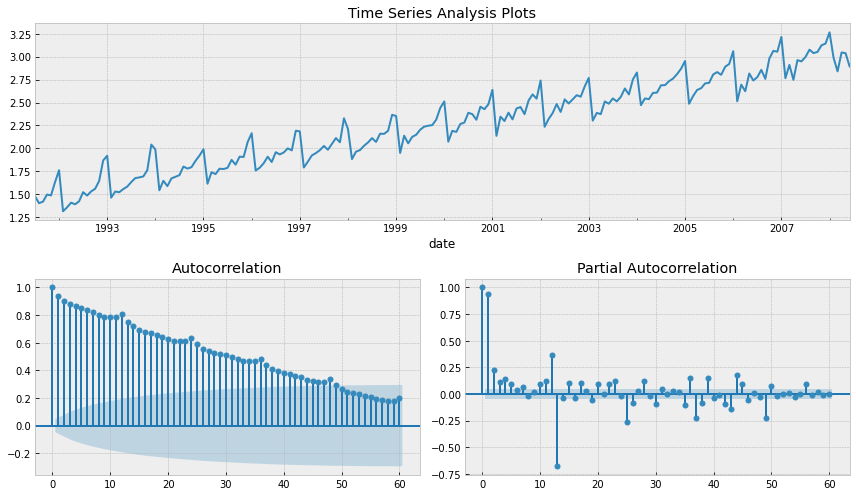

In [230]:
data['value_box'], lmbda = scs.boxcox(data.value+1) # прибавляем единицу, так как в исходном ряде есть нули
tsplot(data.value_box, lags=60)
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

<Figure size 1152x576 with 0 Axes>

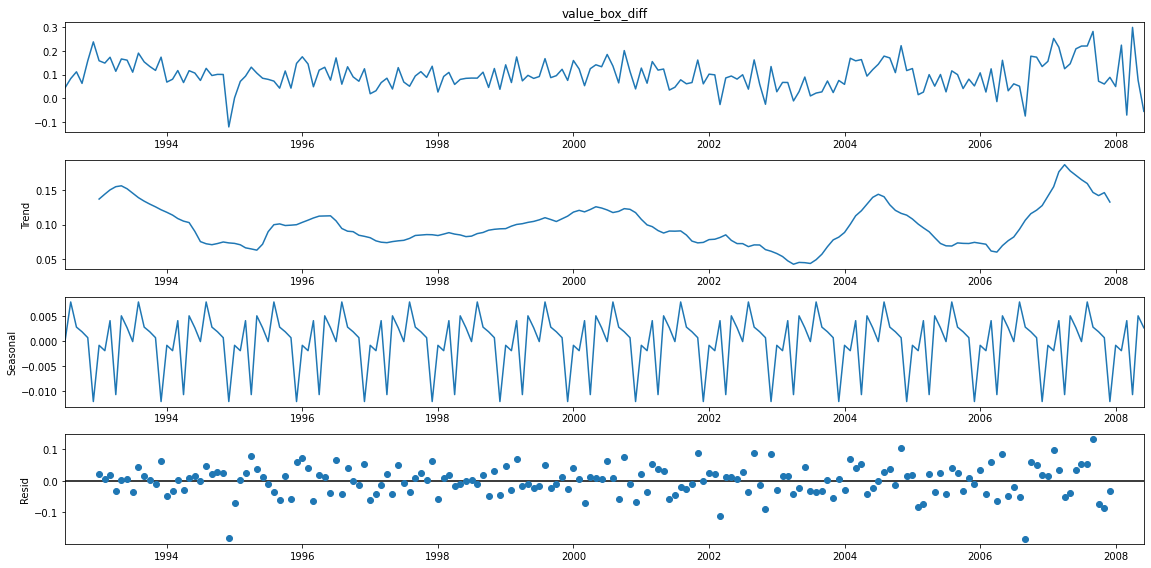

In [236]:
data['value_box_diff'] = data.value_box - data.value_box.shift(12)
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.value_box_diff[12:]).plot()
plt.show()

<Figure size 1152x576 with 0 Axes>

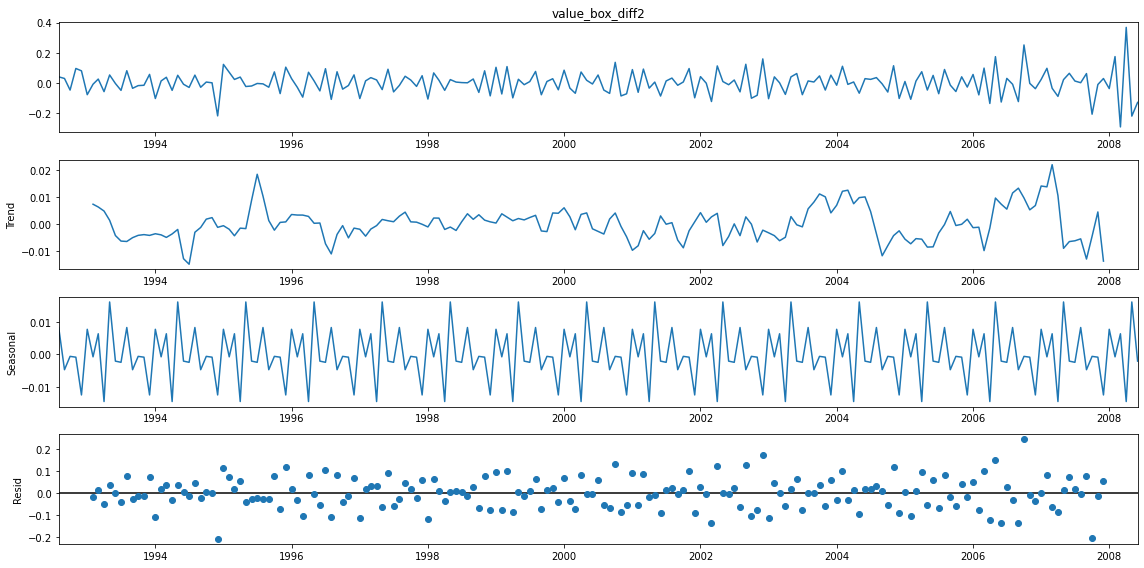

Критерий Дики-Фуллера для преобразованного ряда: pvalue = 5.355891714556633e-05


In [238]:
data['value_box_diff2'] = data.value_box_diff - data.value_box_diff.shift(1)
plt.figure(figsize(16,8))
sm.tsa.seasonal_decompose(data.value_box_diff2[13:]).plot()
plt.show()
print("Критерий Дики-Фуллера для преобразованного ряда: pvalue =",sm.tsa.stattools.adfuller(data.value_box_diff2[13:])[1])

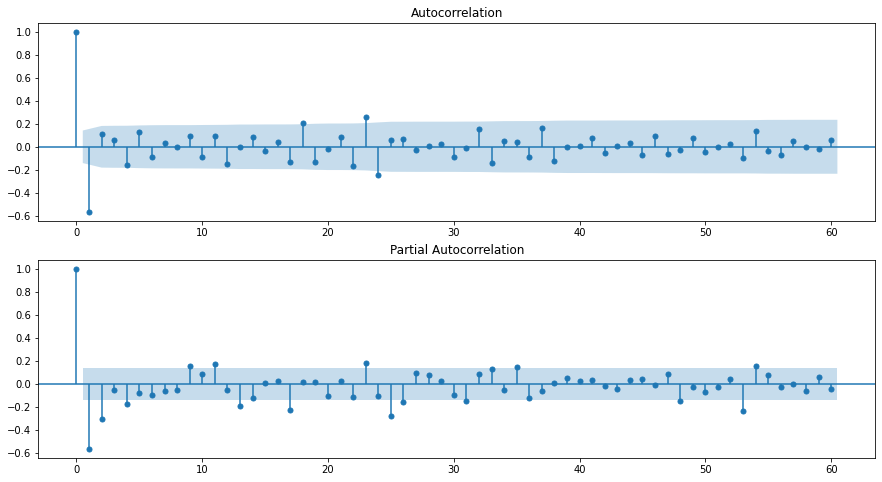

In [239]:

fig, (ax1, ax2) = plt.subplots(nrows=2,figsize=(15,8)) 

sm.graphics.tsa.plot_acf(data.value_box_diff2[13:].values.squeeze(), lags=60, ax=ax1)
sm.graphics.tsa.plot_pacf(data.value_box_diff2[13:].values.squeeze(), lags=60, ax=ax2)

plt.show()

In [242]:
d=D= 1
ps = range(0, 5)
qs = range(0, 2)
Ps = range(0, 3)
Qs = range(0, 3)


parameters = product(ps ,qs, Ps, Qs)
parameters_list = list(parameters)

results = [] # здесь будем хранить результаты
warnings.filterwarnings('ignore') # не для всех параметров модели будут обучаться; отключим предупреждения

for param in tqdm(parameters_list):
    #try-except нужен, чтобы обработать случаи, когда модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.value_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3],12)).fit(disp=-1)
    
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('Wrong parameters:', param)
        continue
    
    results.append([param, model.aic])
    


100%|██████████| 90/90 [03:49<00:00,  2.55s/it]


,Parameters,AIC
88,"(4, 1, 2, 1)",-586.361975
70,"(3, 1, 2, 1)",-585.792619
65,"(3, 1, 0, 2)",-585.506591
89,"(4, 1, 2, 2)",-585.309896
83,"(4, 1, 0, 2)",-584.848898
...,...,...
4,"(0, 0, 1, 1)",-462.014852
1,"(0, 0, 0, 1)",-454.708324
6,"(0, 0, 2, 0)",-445.492365
3,"(0, 0, 1, 0)",-424.675489


In [247]:
result_table = pd.DataFrame(results)
result_table.columns = ['Parameters', 'AIC']
result_table.sort_values(by = 'AIC', ascending=True).head()

,Parameters,AIC
88,"(4, 1, 2, 1)",-586.361975
70,"(3, 1, 2, 1)",-585.792619
65,"(3, 1, 0, 2)",-585.506591
89,"(4, 1, 2, 2)",-585.309896
83,"(4, 1, 0, 2)",-584.848898


In [246]:
best_model=sm.tsa.statespace.SARIMAX(data.value_box, order=(4,1,1), seasonal_order=(2,1,1,12)).fit(disp=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          value_box   No. Observations:                  204
Model:             SARIMAX(4, 1, 1)x(2, 1, 1, 12)   Log Likelihood                 302.181
Date:                            Mon, 28 Jun 2021   AIC                           -586.362
Time:                                    20:34:17   BIC                           -557.092
Sample:                                07-01-1991   HQIC                          -574.506
                                     - 06-01-2008                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2330      0.155     -1.503      0.133      -0.537       0.071
ar.L2          0.0136      0.163   

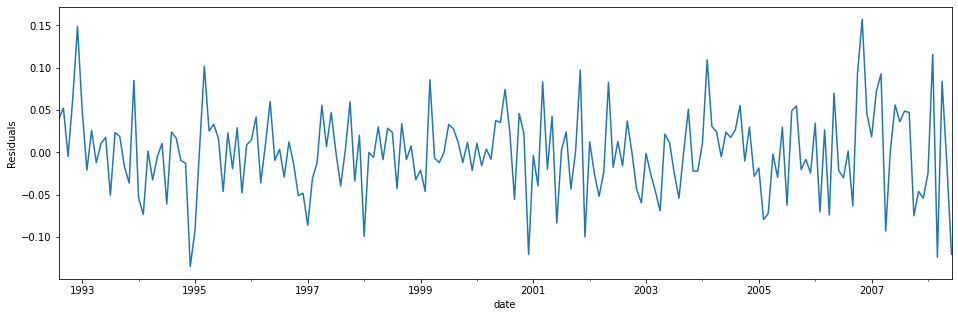

In [248]:
plt.figure(figsize(16,5))
best_model.resid[13:].plot()
plt.ylabel('Residuals')
plt.show()

Критерий знаков для остатков: pvalue = 0.8849851393064638
Критерий Дики-Фуллера для остатков: pvalue = 2.717539533479655e-25


<Figure size 1152x360 with 0 Axes>

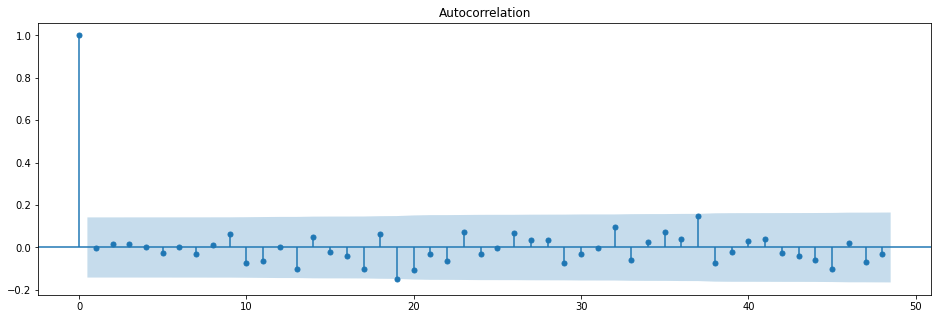

In [249]:
print("Критерий знаков для остатков: pvalue =",sign_test(best_model.resid[13:])[1])
print("Критерий Дики-Фуллера для остатков: pvalue =",sm.tsa.stattools.adfuller(best_model.resid[13:])[1])
plt.figure(figsize(16,5))
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48)
plt.show()

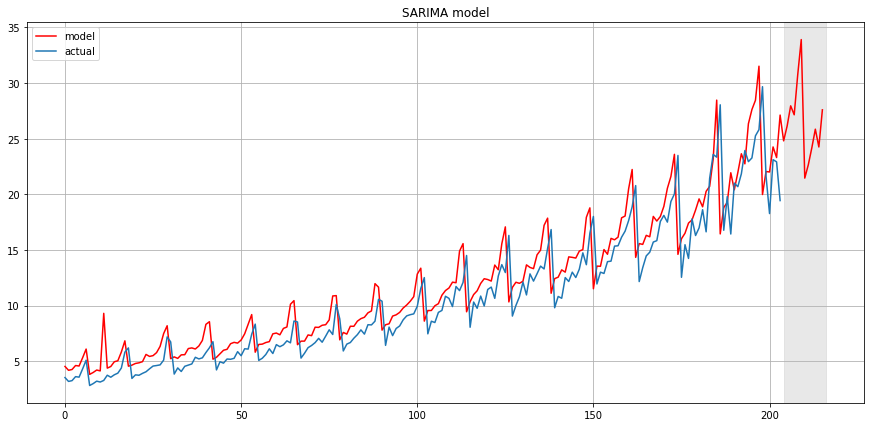

In [257]:
data["model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+12), lmbda)
forecast = data.model.append(forecast).values[-216:]
actual = data.value.values[-204:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model")
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)